# Run dimensionality reduction
This is a part of `run_SPUD_multiple_tests.py` script. Running this notebook will:
- load projection data from pickle files
- ...

TODO: describe used params.

## Setup

### Imports and loading general params

In [9]:
# General imports
import numpy as np
import numpy.linalg as la
import sys, os 
import time, datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle as pkl

# For responsive plot
%matplotlib widget

# Import shared modules
gen_fn_dir = os.path.abspath('.') + '/shared_scripts'
sys.path.append(gen_fn_dir)
import general_file_fns as gff
from binned_spikes_class import spike_counts
from dim_red_fns import run_dim_red

# Get current date
curr_date = datetime.datetime.now().strftime('%Y_%m_%d')+'_'

# Load and print general params and create directory to load dimensionality reduction results if needed
gen_params = gff.load_pickle_file('./general_params/general_params.pkl')
print(f"General params used for this session:\n{gen_params}")

Reading data from ./general_params/general_params.pkl...
General params used for this session:
{'raw_data_dir': './data/raw_data/', 'processed_data_dir': './data/processed/', 'kernel_rates_dir': './data/analyses/kernel_rates/', 'results_dir': './data/analyses/', 'cols': {'REM': (0.392, 0.549, 0.0784), 'SWS': (0.824, 0.627, 0.0392), 'Wake': (0.0118, 0.235, 0.392), 'measured': (0.3, 0.3, 0.3), 'fit': (0.49, 0.961, 0.961)}}


### Load projections

In [11]:
# Load projections from pickle files created by dim_red
embeddings_path = "./data/analyses/dim_red/Mouse28-140313_Wake_iso_3_embeddings_2023_06_12_.pkl"
print(f"Loading embeddings from {embeddings_path}")
with open(embeddings_path, "rb") as f:
    embeddings = pkl.load(f)

print(f"Loaded embedding dict with keys:")
print(embeddings.keys())

Loading embeddings from ./data/analyses/dim_red/Mouse28-140313_Wake_iso_3_embeddings_2023_06_12_.pkl
Loaded embedding dict with keys:
dict_keys(['Wake', 'meas_angles'])


### Load used params

In [13]:
params_path = "./data/analyses/dim_red/Mouse28-140313_Wake_iso_3_used_params_2023_06_12_.pkl"
print(f"Loading parameters from {params_path}")
with open(params_path, "rb") as f:
    params = pkl.load(f)
# TODO describe used params
print(f"Loaded params used in dim_red part:")
for v,k in params.items():
    print(f"{v}: {k}")

Loading parameters from ./data/analyses/dim_red/Mouse28-140313_Wake_iso_3_used_params_2023_06_12_.pkl
Loaded params used in dim_red part:
session: Mouse28-140313
fit_dim: 3
nKnots: 15
knot_order: wt_per_len
penalty_type: mult_len
nTests: 10
train_frac: 0.8
area: ADn
state: Wake
dt_kernel: 0.1
sigma: 0.1
method: iso
n_neighbors: 5
dt: 0.1
target_dim: 3
desired_nSamples: 15000


### Set fit params

In [27]:
session = params["session"]
fit_params = {'dalpha' : 0.005, 'knot_order' : params['knot_order'], 'penalty_type' : params['penalty_type'], 'nKnots' : params['nKnots']}
current_manifold = embeddings[params['state']]
current_manifold.shape

(15000, 3)

In [26]:
train_frac = params['train_frac']
nPoints = len(current_manifold) # current_manifold.shape[0]
nTrain = np.round(train_frac * nPoints).astype(int)
print(f"Use {nTrain = } training samples ({train_frac} of all point in the manifold.)")

Use nTrain = 12000 training samples (0.8 of all point in the manifold.)


### Examine measured angles

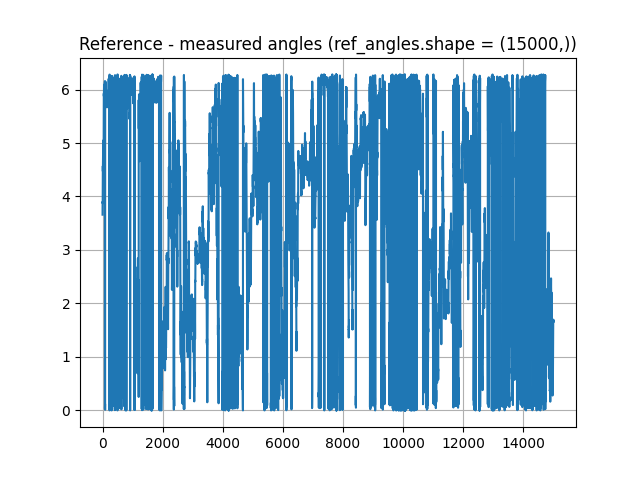

In [31]:
ref_angles = embeddings['meas_angles']
fig, ax = plt.subplots(1,1)
ax.plot(ref_angles)
ax.set_title(f"Reference - measured angles ({ref_angles.shape = })")
ax.grid()
plt.show()

## Fit the spline

In [ ]:
# Unpack repeated parameters
# Note: I don't understand why some of them are even defined in dim red part
nTests = params["nTests"] # number of random splits on which training and evaluation is performed. This is not k-fold cross-validation though.
nKnots = params["nKnots"]
knot_order = params["knot_order"]
penalty_type = params["penalty_type"]
k = (session, params['fit_dim'], nKnots, knot_order, penalty_type, train_frac) # Whats this?

# Create dict for results
results = {}

# Start fitting the manifold
tic = time.time()
print('Fitting manifold...')

# TODO change it to k-Fold cross validation?
for curr_sample in range(nTests):
    # Randomly split data into train and test split
    train_idx = np.random.choice(nPoints, size=nTrain, replace=False)
    test_idx = np.array([idx for idx in range(nPoints) if idx not in train_idx])
    train_data = current_manifold[train_idx].copy()
    test_data = current_manifold[test_idx].copy()
    # Fit the training data
    curr_fit_result = mff.fit_manifold(train_data, fit_params)
    # Decode the angles in test data
    decoded_angle, mse = mff.decode_from_passed_fit(
        test_data, 
        curr_fit_result['tt'][:-1], # TODO what is "tt"?
        curr_fit_result['curve'][:-1], 
        ref_angles[test_idx])
    if k in results:
        results[k].append([mse, curr_fit_result['fit_err'], np.array(curr_fit_result['final_knots'])])
    else:
        results[k] = [[mse, curr_fit_result['fit_err'], np.array(curr_fit_result['final_knots'])]]
print(f'Fitting time: {(time.time()-tic):.2f}s.')

In [ ]:
to_save = {
    'fit_results' : results, 
    'session' : session, 
    'area' : area, 
    'state' : state, 
    'embeddings_file' : embeddings_fname
    } 
gff.save_pickle_file(to_save, dir_to_save + '%s_%s_dim%d_trainfrac%.2f_decode_errors_sd%d.pkl'%(session, state, fit_dim, train_frac, sd))


In [ ]:

rmse_to_plot = np.sqrt([x[0] for x in results[k]])

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
if nTests<20:
    ax.scatter(np.ones_like(rmse_to_plot), rmse_to_plot)
    ax.set_xticks([1])
    # ax.set_xticklabels(['Samples'])
else:
    vp = ax.violinplot([rmse_to_plot], positions=[1], points=100,
        widths=0.75, showmeans=True, showextrema=False, showmedians=True)
ax.set_xlim([0,2])
ax.set_ylabel('Root mean squared error (rad)')
ax.set_ylim([0,1.8])
plt.show()
